In [3]:
! pip install scapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.9 MB/s eta 0:00:00


In [ ]:
# Roll Nos -> 23110054, 23110030
# X = (54+30) % 10 = 4

In [6]:
import json

IP_POOL = [
    "192.168.1.1", "192.168.1.2", "192.168.1.3", "192.168.1.4", "192.168.1.5",
    "192.168.1.6", "192.168.1.7", "192.168.1.8", "192.168.1.9", "192.168.1.10",
    "192.168.1.11", "192.168.1.12", "192.168.1.13", "192.168.1.14", "192.168.1.15"
]

rules = {
  "morning": {"time_range": "04:00-11:59", "hash_mod": 5, "ip_pool_start": 0},
  "afternoon": {"time_range": "12:00-19:59", "hash_mod": 5, "ip_pool_start": 5},
  "night": {"time_range": "20:00-03:59", "hash_mod": 5, "ip_pool_start": 10}
}

def select_ip(custom_header):
    hh = int(custom_header[0:2])
    ssid = int(custom_header[-2:])

    if 4 <= hh <= 11:
        period = 'morning'
    elif 12 <= hh <= 19:
        period = 'afternoon'
    else:
        period = 'night'

    rule = rules[period]
    index = rule['ip_pool_start'] + (ssid % rule['hash_mod'])
    return IP_POOL[index]


In [7]:
from scapy.layers.dns import DNSQR

def server_simulation(custom_header, dns_query_bytes):
    dnsqr = DNSQR(dns_query_bytes)
    domain_name = dnsqr.qname.decode() if hasattr(dnsqr, 'qname') else 'unknown.com'
    selected_ip = select_ip(custom_header)

    return domain_name, selected_ip


In [9]:
from scapy.all import rdpcap, DNSQR
import time
import pandas as pd

PCAP_FILE = '4.pcap'  # Update with your file path
report = []

def get_custom_header(query_id):
    timestamp = time.strftime("%H%M%S")  # HHMMSS
    return f"{timestamp}{query_id:02}".encode()

def run_client():
    print("[CLIENT] Reading PCAP file...")
    packets = rdpcap(PCAP_FILE)
    dns_queries = [p for p in packets if p.haslayer(DNSQR)]

    print(f"[CLIENT] Found {len(dns_queries)} DNS queries.")

    for idx, packet in enumerate(dns_queries):
        custom_header = get_custom_header(idx)
        dnsqr = packet[DNSQR]
        domain_name = dnsqr.qname.decode()

        original_dns_bytes = bytes(dnsqr)

        # Simulate server processing in same notebook
        extracted_domain, resolved_ip = server_simulation(custom_header.decode(), original_dns_bytes)

        print(f"[CLIENT] {custom_header.decode()} | {extracted_domain} | {resolved_ip}")

        report.append({
            'custom_header': custom_header.decode(),
            'domain_name': extracted_domain,
            'resolved_ip': resolved_ip
        })

    # Save report
    df = pd.DataFrame(report)
    report_path = 'dns_resolution_report.csv'
    df.to_csv(report_path, index=False)
    print(f"\n[CLIENT] Report saved at {report_path}")

run_client()


[CLIENT] Reading PCAP file...
[CLIENT] Found 86 DNS queries.
[CLIENT] 09330000 | _apple-mobdev._tcp.local. | 192.168.1.1
[CLIENT] 09330001 | _apple-mobdev._tcp.local. | 192.168.1.2
[CLIENT] 09330002 | linkedin.com. | 192.168.1.3
[CLIENT] 09330003 | wikipedia.org. | 192.168.1.4
[CLIENT] 09330004 | wpad. | 192.168.1.5
[CLIENT] 09330005 | wpad. | 192.168.1.1
[CLIENT] 09330006 | wpad. | 192.168.1.2
[CLIENT] 09330007 | wpad. | 192.168.1.3
[CLIENT] 09330008 | wpad. | 192.168.1.4
[CLIENT] 09330009 | wpad. | 192.168.1.5
[CLIENT] 09330010 | wpad. | 192.168.1.1
[CLIENT] 09330011 | wpad. | 192.168.1.2
[CLIENT] 09330012 | gmxwnlajnl. | 192.168.1.3
[CLIENT] 09330013 | djoncbjcmv. | 192.168.1.4
[CLIENT] 09330014 | mptrmkwart. | 192.168.1.5
[CLIENT] 09330015 | djoncbjcmv. | 192.168.1.1
[CLIENT] 09330016 | gmxwnlajnl. | 192.168.1.2
[CLIENT] 09330017 | mptrmkwart. | 192.168.1.3
[CLIENT] 09330018 | Brother MFC-7860DW._pdl-datastream._tcp.local. | 192.168.1.4
[CLIENT] 09330019 | Brother MFC-7860DW._pdl-d

In [2]:
import pandas as pd

df = pd.read_csv('dns_resolution_report.csv')
df


,custom_header,domain_name,resolved_ip
0,9330000,_apple-mobdev._tcp.local.,192.168.1.1
1,9330001,_apple-mobdev._tcp.local.,192.168.1.2
2,9330002,linkedin.com.,192.168.1.3
3,9330003,wikipedia.org.,192.168.1.4
4,9330004,wpad.,192.168.1.5
...,...,...,...
81,9330081,wpad.,192.168.1.2
82,9330082,wpad.,192.168.1.3
83,9330083,wpad.,192.168.1.4
84,9330084,wpad.,192.168.1.5


In [4]:
domain_counts = df['domain_name'].value_counts()
domain_counts

,count
domain_name,
wpad.,44
Brother MFC-7860DW._pdl-datastream._tcp.local.,12
isatap.,8
_apple-mobdev._tcp.local.,5
isilon.,4
djoncbjcmv.,2
gmxwnlajnl.,2
mptrmkwart.,2
wikipedia.org.,1


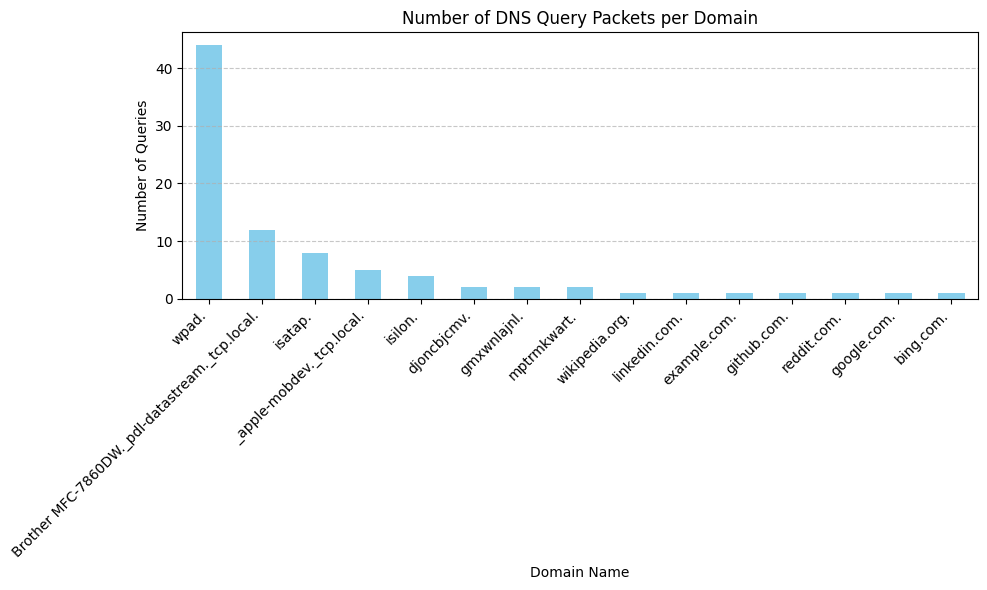

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
domain_counts.plot(kind='bar', color='skyblue')

plt.title('Number of DNS Query Packets per Domain')
plt.xlabel('Domain Name')
plt.ylabel('Number of Queries')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [9]:
# To see how many times each resolved IP appears:
ip_counts = df['resolved_ip'].value_counts()
ip_counts

,count
resolved_ip,
192.168.1.1,18
192.168.1.2,17
192.168.1.3,17
192.168.1.4,17
192.168.1.5,17


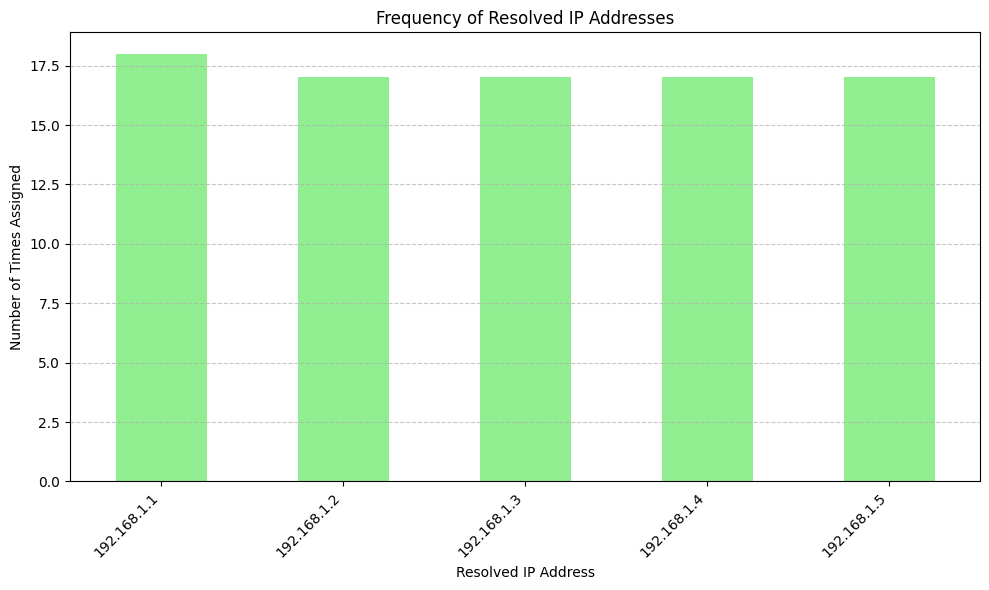

In [8]:

plt.figure(figsize=(10, 6))
ip_counts.plot(kind='bar', color='lightgreen')

plt.title('Frequency of Resolved IP Addresses')
plt.xlabel('Resolved IP Address')
plt.ylabel('Number of Times Assigned')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
